# 🛍️ **Customer Churn Prediction in E-commerce with Google Cloud**


This project aims to **predict customer churn behavior** in an e-commerce environment, using the publicly available **[TheLook eCommerce dataset](https://console.cloud.google.com/marketplace/product/bigquery-public-data/thelook-ecommerce)** hosted on **Google BigQuery**.


---

## 📌 Project Overview

The ultimate goal is to support marketing and retention strategies by identifying which customers are most likely to stop purchasing, allowing the business to take proactive actions before they churn.

Customer churn is a critical problem for online retailers, as acquiring new customers is often more expensive than retaining existing ones. Through data exploration, survival analysis, and machine learning, this project will seek to uncover patterns in customer behavior and build predictive models that estimate churn risk with actionable accuracy.

---

## 📦 Data Source

The dataset used in this project is provided by **Google BigQuery Public Datasets**, specifically the `thelook_ecommerce` dataset, which simulates a real-world e-commerce operation. It contains structured tables with information on:

- **Users** (demographics, location)
- **Orders** (order lifecycle dates and status)
- **Order Items** (details on products purchased per order)
- **Inventory Items** (product-level metadata)

---

## 🛠️ Methodology: First Steps

1. **Data Extraction**

2. **Raw Data Aggregation**

3. **Exploratory Data Analysis**

4. **Defining Churn**

5. **Consolidating the Dataset**

---

This notebook will guide the reader through the complete lifecycle of the churn prediction project — from data acquisition and preparation, through analysis and modeling, to business-oriented insights and strategic recommendations.



In [1]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime

##**1. Extracting Data from BigQuery**
   - Using SQL within Python, we'll query the necessary tables from BigQuery and join them into a consolidated dataset.
   - Fields selected include customer information (age, gender, location), order behavior (status, date), and purchased products details (category, price).

In [2]:
client = bigquery.Client(project="portfolio-project-464320")

In [3]:
query = '''
SELECT
  ii.product_id,
  ii.product_name,
  ii.product_category,
  ii.product_department,
  oi.order_id,
  oi.sale_price,
  o.user_id,
  o.gender,
  o.status,
  o.created_at,
  o.shipped_at,
  o. delivered_at,
  o.returned_at,
  u.age,
  u.state,
  u.city
FROM `bigquery-public-data.thelook_ecommerce.users` u
JOIN `bigquery-public-data.thelook_ecommerce.order_items` oi ON u.id = oi.user_id
JOIN `bigquery-public-data.thelook_ecommerce.inventory_items` ii ON oi.product_id = ii.product_id
JOIN `bigquery-public-data.thelook_ecommerce.orders` o ON oi.order_id = o.order_id;
'''
df = client.query(query).to_dataframe()

In [4]:
df.head()

,product_id,product_name,product_category,product_department,order_id,sale_price,user_id,gender,status,created_at,shipped_at,delivered_at,returned_at,age,state,city
0,14235,Indestructable Aluminum Aluma Wallet - RED,Accessories,Women,120204,0.02,96253,F,Cancelled,2024-12-30 10:29:00+00:00,NaT,NaT,NaT,50,Ohio,Kirtland
1,14235,Indestructable Aluminum Aluma Wallet - RED,Accessories,Women,120204,0.02,96253,F,Cancelled,2024-12-30 10:29:00+00:00,NaT,NaT,NaT,50,Ohio,Kirtland
2,14235,Indestructable Aluminum Aluma Wallet - RED,Accessories,Women,120204,0.02,96253,F,Cancelled,2024-12-30 10:29:00+00:00,NaT,NaT,NaT,50,Ohio,Kirtland
3,14235,Indestructable Aluminum Aluma Wallet - RED,Accessories,Women,120204,0.02,96253,F,Cancelled,2024-12-30 10:29:00+00:00,NaT,NaT,NaT,50,Ohio,Kirtland
4,14235,Indestructable Aluminum Aluma Wallet - RED,Accessories,Women,120204,0.02,96253,F,Cancelled,2024-12-30 10:29:00+00:00,NaT,NaT,NaT,50,Ohio,Kirtland


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3563008 entries, 0 to 3563007
Data columns (total 16 columns):
 #   Column              Dtype              
---  ------              -----              
 0   product_id          Int64              
 1   product_name        object             
 2   product_category    object             
 3   product_department  object             
 4   order_id            Int64              
 5   sale_price          float64            
 6   user_id             Int64              
 7   gender              object             
 8   status              object             
 9   created_at          datetime64[us, UTC]
 10  shipped_at          datetime64[us, UTC]
 11  delivered_at        datetime64[us, UTC]
 12  returned_at         datetime64[us, UTC]
 13  age                 Int64              
 14  state               object             
 15  city                object             
dtypes: Int64(4), datetime64[us, UTC](4), float64(1), object(7)
memory usage:

Removing hours, minutes, and seconds from our datetime information. For this project, only the date is relevant.

In [6]:
cols_to_convert = ['created_at', 'shipped_at', 'delivered_at', 'returned_at']

for col in cols_to_convert:
    df[col] =  df[col].dt.strftime('%Y-%m-%d')
    df[col] =  pd.to_datetime(df[col])

In [7]:
df.count()

,0
product_id,3563008
product_name,3563008
product_category,3563008
product_department,3563008
order_id,3563008
sale_price,3563008
user_id,3563008
gender,3563008
status,3563008
created_at,3563008


Due to the joins in our SQL query, some rows contain duplicated information. We need to remove these duplicates at this stage.

In [8]:
df.duplicated().sum()

np.int64(3381829)

In [9]:
df.drop_duplicates(inplace = True)

##**2. Separating a table with Clients Information (clients_info) from Raw Data (df)**
   - We'll store the raw query result in a Pandas DataFrame (`df`) to be used as our core dataset.
   - Then, we'll create a customer-level summary table (`clients_info`) aggregating key behavior metrics like:
     - Number of purchases
     - First and last order dates
     - Recency
     - Total and average spend

In [10]:
clients_info = df.groupby('user_id')['order_id'].nunique().reset_index()
clients_info.rename(columns={'order_id': 'number_of_orders'}, inplace=True)

In [11]:
clients_info['first_order_date'] = df.groupby('user_id')['created_at'].min().reset_index()['created_at']

In [12]:
clients_info['last_order_date'] = df.groupby('user_id')['created_at'].max().reset_index()['created_at']

In [13]:
date_today = pd.Timestamp.today().normalize()

In [14]:
clients_info['recency'] = (date_today - clients_info['last_order_date']).dt.days

In [15]:
clients_info['total_spent'] = df.groupby('user_id')['sale_price'].sum().reset_index()['sale_price']

In [16]:
clients_info['average_ticket'] = clients_info['total_spent'] / clients_info['number_of_orders']

In [17]:
user_demo = df[['user_id', 'gender', 'age']].drop_duplicates(subset='user_id')

duplicados = user_demo.duplicated(subset='user_id', keep=False)
if duplicados.any():
    print("⚠️ Atenção: Há usuários com mais de um gênero ou idade diferente.")
    print(user_demo[duplicados].sort_values('user_id'))

# Faz o merge com clients_info
clients_info = clients_info.merge(user_demo, on='user_id', how='left')

In [18]:
clients_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80099 entries, 0 to 80098
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user_id           80099 non-null  Int64         
 1   number_of_orders  80099 non-null  int64         
 2   first_order_date  80099 non-null  datetime64[ns]
 3   last_order_date   80099 non-null  datetime64[ns]
 4   recency           80099 non-null  int64         
 5   total_spent       80099 non-null  float64       
 6   average_ticket    80099 non-null  float64       
 7   gender            80099 non-null  object        
 8   age               80099 non-null  Int64         
dtypes: Int64(2), datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 5.7+ MB


In [19]:
# Extracting unique order's date per user_id (in occuring order)
date_lists = df.groupby('user_id')['created_at'].unique().apply(lambda x: sorted(pd.to_datetime(x).date))

# Transformating Series into a DataFrame
orders_df = date_lists.apply(pd.Series)
orders_df.columns = ['order_1', 'order_2', 'order_3', 'order_4']
orders_df = orders_df.reset_index()

cols_to_convert = ['order_1', 'order_2', 'order_3', 'order_4']

for col in cols_to_convert:
#    df[col] =  df[col].dt.strftime('%Y-%m-%d')
    orders_df[col] =  pd.to_datetime(orders_df[col])

# Result
orders_df

,user_id,order_1,order_2,order_3,order_4
0,3,2023-03-05,NaT,NaT,NaT
1,4,2021-09-20,NaT,NaT,NaT
2,5,2021-01-28,NaT,NaT,NaT
3,6,2025-05-15,2025-06-28,NaT,NaT
4,7,2022-11-06,NaT,NaT,NaT
...,...,...,...,...,...
80094,99993,2022-09-22,2022-12-13,2023-01-30,NaT
80095,99996,2022-02-20,NaT,NaT,NaT
80096,99997,2025-06-14,NaT,NaT,NaT
80097,99999,2019-11-11,NaT,NaT,NaT


In [20]:
clients_info = pd.merge(
    clients_info,
    orders_df[['user_id', 'order_1', 'order_2', 'order_3', 'order_4']],
    on='user_id',
    how='left'
)

In [21]:
clients_info

,user_id,number_of_orders,first_order_date,last_order_date,recency,total_spent,average_ticket,gender,age,order_1,order_2,order_3,order_4
0,3,1,2023-03-05,2023-03-05,851,77.000000,77.000000,M,57,2023-03-05,NaT,NaT,NaT
1,4,1,2021-09-20,2021-09-20,1382,148.000000,148.000000,M,18,2021-09-20,NaT,NaT,NaT
2,5,1,2021-01-28,2021-01-28,1617,129.480000,129.480000,F,56,2021-01-28,NaT,NaT,NaT
3,6,2,2025-05-15,2025-06-28,5,173.000000,86.500000,F,66,2025-05-15,2025-06-28,NaT,NaT
4,7,1,2022-11-06,2022-11-06,970,105.949997,105.949997,M,38,2022-11-06,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80094,99993,3,2022-09-22,2023-01-30,885,446.950000,148.983333,F,53,2022-09-22,2022-12-13,2023-01-30,NaT
80095,99996,1,2022-02-20,2022-02-20,1229,19.990000,19.990000,M,59,2022-02-20,NaT,NaT,NaT
80096,99997,1,2025-06-14,2025-06-14,19,40.720001,40.720001,F,27,2025-06-14,NaT,NaT,NaT
80097,99999,1,2019-11-11,2019-11-11,2061,154.350006,154.350006,M,12,2019-11-11,NaT,NaT,NaT


## **3. Exploratory and Descritive Analysis - EDA**
   We'll analyze customer patterns of behavior using visualizations and statistical summaries.

### **3.1 Number of orders per clients**

In [22]:
clients_info['number_of_orders'].value_counts(normalize = True)*100

,proportion
number_of_orders,
1,62.595039
2,25.046505
4,6.228542
3,6.129914


<Axes: xlabel='number_of_orders', ylabel='Count'>

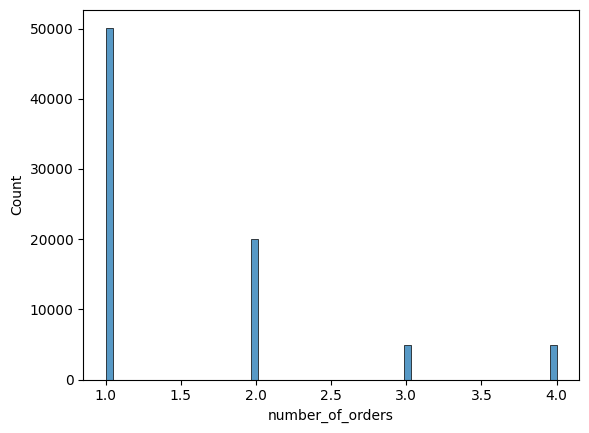

In [23]:
sns.histplot(data = clients_info, x = 'number_of_orders')

In [24]:
clients_info['number_of_orders'].unique()

array([1, 2, 4, 3])

On this first analysis, we can notice that:


*   Most of clients only buy once.
*   Most of clients que buy twice, don't do the third purchase. However, they have more inclination do to a third shop than the one who just did once has to do a second.
*   There's a clear **activation effect**: the client who makes the third purchase is the most likely to continue buying.

---

#### 📌 1. Customers with Only 1 Purchase  
**Problem**: Activation  
**Goal**: Predict whether the customer will make a second purchase  
**Suggested Model**: Binary classification (Will purchase again: yes or no)  
**Useful Features**:  
- Days since first purchase  
- Average ticket  
- Product category  
- Entry channel (e.g., campaign, platform)  
- Geographic data (city/state)

---

#### 📌 2. Customers with 2 Purchases  
**Problem**: Early stage of loyalty  
**Goal**: Predict if the customer will become recurrent (make a 3rd purchase)  
**Suggested Model**: Another binary classifier (Will make a third purchase: yes or no)  
**Complementary Analysis**: Kaplan-Meier curve to estimate ideal time between 2nd and 3rd purchases

---

#### 📌 3. Customers with 3 or More Purchases  
**Problem**: Loyalty maintenance and churn prevention  
**Goal**: Predict time until churn or likelihood of new purchases  
**Suggested Models**:  
- **Survival models** (e.g., Cox Regression, Random Survival Forests)  
- **Churn classifiers** using recency, frequency, and monetary value as key features

### Number of orders per clients conclusion
Based on the distribution of customers by number of purchases, we realize that a more effective approach to churn prediction is to **segment customers by their purchase stage** and build **dedicated models** for each group.

### **3.2 Number of Orders vs Recency**

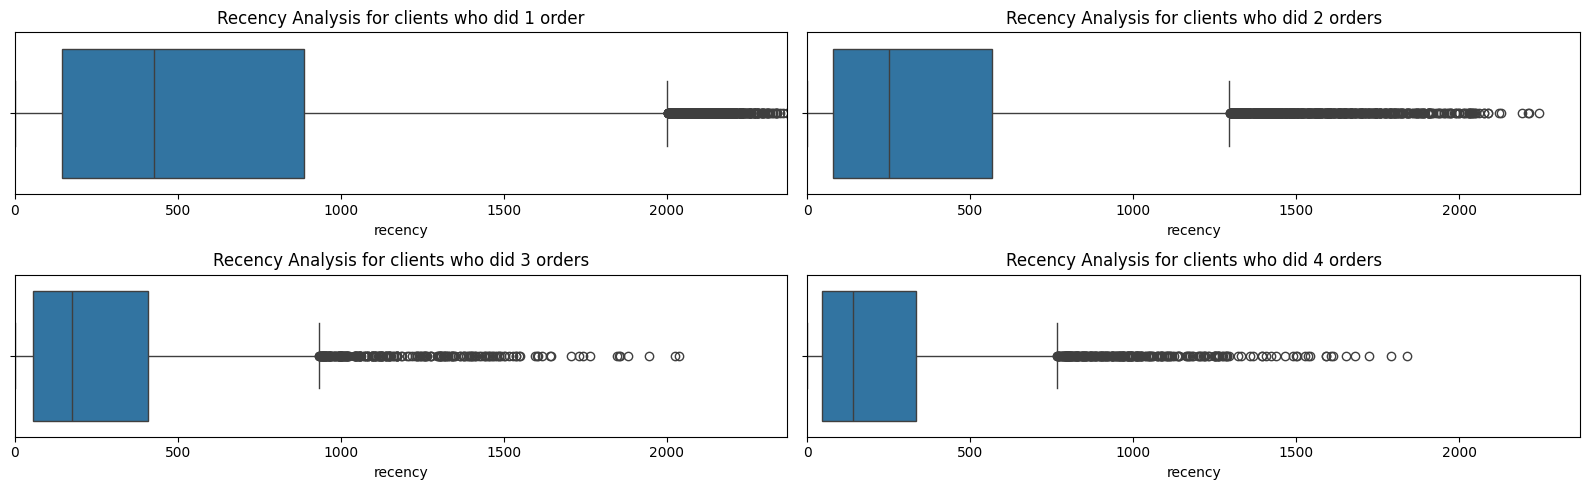

In [25]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16,5))
max_recency = clients_info.query('number_of_orders in [1, 2, 3, 4]')['recency'].max()

sns.boxplot(data = clients_info.query('number_of_orders == 1'), x = 'recency', orient = 'h', ax = ax1)
ax1.set_title('Recency Analysis for clients who did 1 order')
ax1.set_xlim(0, max_recency)
sns.boxplot(data = clients_info.query('number_of_orders == 2'), x = 'recency', orient = 'h', ax = ax2)
ax2.set_title('Recency Analysis for clients who did 2 orders')
ax2.set_xlim(0, max_recency)
sns.boxplot(data = clients_info.query('number_of_orders == 3'), x = 'recency', orient = 'h', ax = ax3)
ax3.set_title('Recency Analysis for clients who did 3 orders')
ax3.set_xlim(0, max_recency)
sns.boxplot(data = clients_info.query('number_of_orders == 4'), x = 'recency', orient = 'h', ax = ax4)
ax4.set_title('Recency Analysis for clients who did 4 orders')
ax4.set_xlim(0, max_recency)

plt.tight_layout()
plt.show()

### Number of orders per recency conclusion
Loyal clients have purchased more recently, on average, than sporadic clients who bought only once or twice. This means that most one-time customers made their purchases a long time ago.

### **3.3 Number of Orders vs Average Ticket**

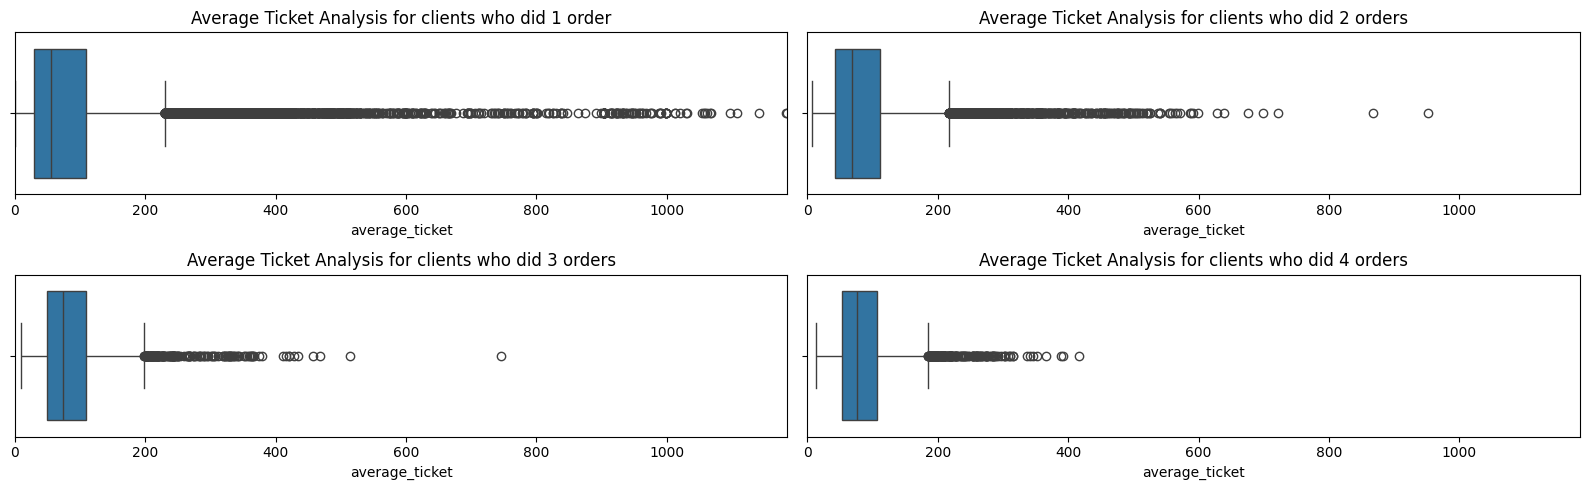

In [26]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16,5))
max_avg_ticket = clients_info.query('number_of_orders in [1, 2, 3, 4]')['average_ticket'].max()
#max_avg_ticket = 400

sns.boxplot(data = clients_info.query('number_of_orders == 1'), x = 'average_ticket', orient = 'h', ax = ax1)
ax1.set_title('Average Ticket Analysis for clients who did 1 order')
ax1.set_xlim(0, max_avg_ticket)
sns.boxplot(data = clients_info.query('number_of_orders == 2'), x = 'average_ticket', orient = 'h', ax = ax2)
ax2.set_title('Average Ticket Analysis for clients who did 2 orders')
ax2.set_xlim(0, max_avg_ticket)
sns.boxplot(data = clients_info.query('number_of_orders == 3'), x = 'average_ticket', orient = 'h', ax = ax3)
ax3.set_title('Average Ticket Analysis for clients who did 3 orders')
ax3.set_xlim(0, max_avg_ticket)
sns.boxplot(data = clients_info.query('number_of_orders == 4'), x = 'average_ticket', orient = 'h', ax = ax4)
ax4.set_title('Average Ticket Analysis for clients who did 4 orders')
ax4.set_xlim(0, max_avg_ticket)

plt.tight_layout()
plt.show()

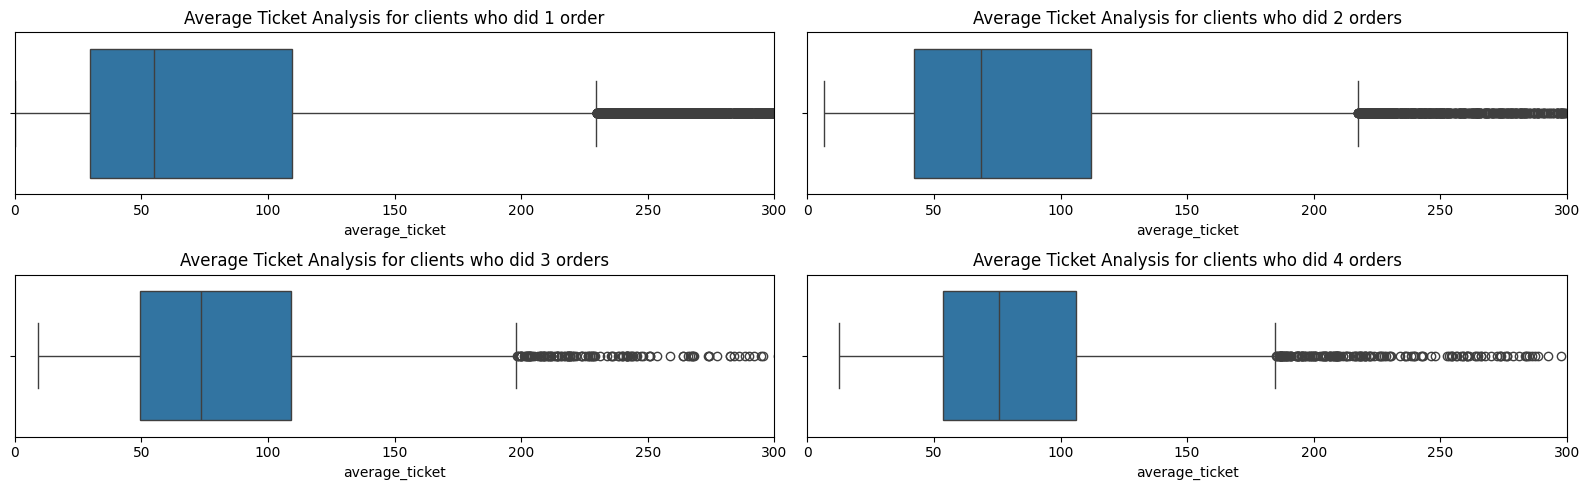

In [27]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16,5))
#max_avg_ticket = clients_info.query('number_of_orders in [1, 2, 3, 4]')['average_ticket'].max()
max_avg_ticket = 300

sns.boxplot(data = clients_info.query('number_of_orders == 1'), x = 'average_ticket', orient = 'h', ax = ax1)
ax1.set_title('Average Ticket Analysis for clients who did 1 order')
ax1.set_xlim(0, max_avg_ticket)
sns.boxplot(data = clients_info.query('number_of_orders == 2'), x = 'average_ticket', orient = 'h', ax = ax2)
ax2.set_title('Average Ticket Analysis for clients who did 2 orders')
ax2.set_xlim(0, max_avg_ticket)
sns.boxplot(data = clients_info.query('number_of_orders == 3'), x = 'average_ticket', orient = 'h', ax = ax3)
ax3.set_title('Average Ticket Analysis for clients who did 3 orders')
ax3.set_xlim(0, max_avg_ticket)
sns.boxplot(data = clients_info.query('number_of_orders == 4'), x = 'average_ticket', orient = 'h', ax = ax4)
ax4.set_title('Average Ticket Analysis for clients who did 4 orders')
ax4.set_xlim(0, max_avg_ticket)

plt.tight_layout()
plt.show()

### Number of orders per average ticket conclusion
Loyal clients have, on average, a higher average ticker on its purchases. This difference is more visible when it comes to clients who did 4 orders. Even though, there are a great amount of non-loyal customers with high ticket purchases

### **3.4 Number_of_orders VS  Age and Gender**

In [28]:
pd.crosstab(clients_info.number_of_orders, clients_info.gender)

gender,F,M
number_of_orders,,
1,25164,24974
2,9844,10218
3,2483,2427
4,2510,2479


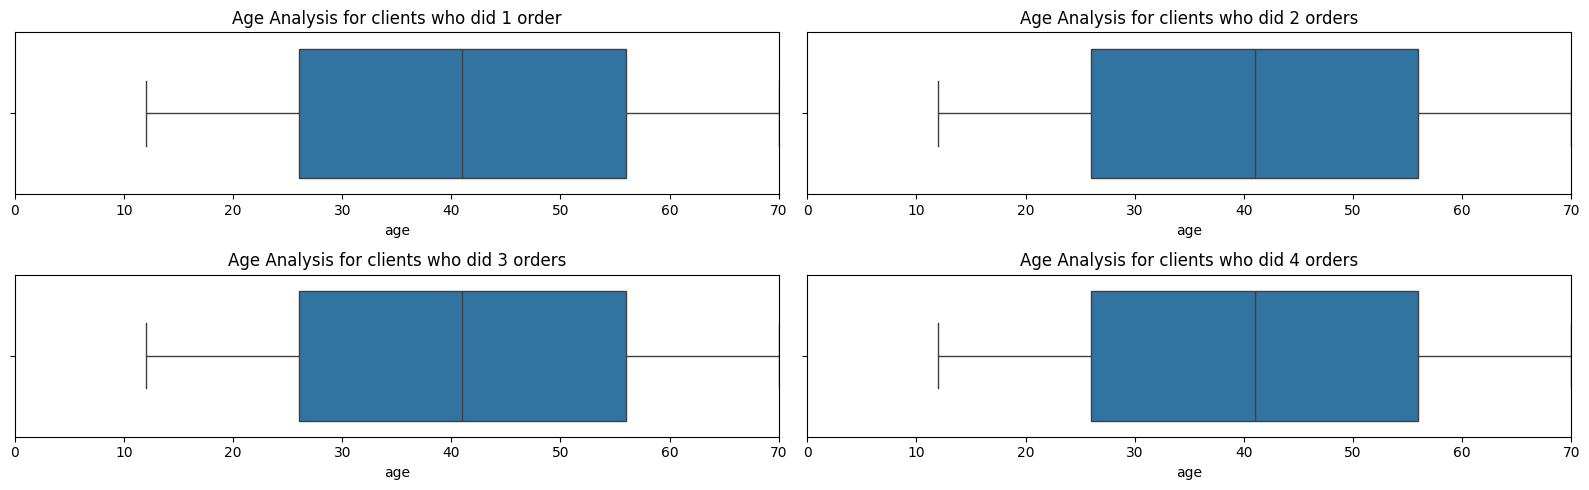

In [29]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16,5))
max_age = clients_info.query('number_of_orders in [1, 2, 3, 4]')['age'].max()

sns.boxplot(data = clients_info.query('number_of_orders == 1'), x = 'age', orient = 'h', ax = ax1)
ax1.set_title('Age Analysis for clients who did 1 order')
ax1.set_xlim(0, max_age)
sns.boxplot(data = clients_info.query('number_of_orders == 2'), x = 'age', orient = 'h', ax = ax2)
ax2.set_title('Age Analysis for clients who did 2 orders')
ax2.set_xlim(0, max_age)
sns.boxplot(data = clients_info.query('number_of_orders == 3'), x = 'age', orient = 'h', ax = ax3)
ax3.set_title('Age Analysis for clients who did 3 orders')
ax3.set_xlim(0, max_age)
sns.boxplot(data = clients_info.query('number_of_orders == 4'), x = 'age', orient = 'h', ax = ax4)
ax4.set_title('Age Analysis for clients who did 4 orders')
ax4.set_xlim(0, max_age)

plt.tight_layout()
plt.show()

### Number of orders per gender and age conclusion
There's no statistical influence of gender and age on the amount of a client's purchases.

## **4. Defining Churn**
Define whats is a churn is a huge and very important strategy, since a wrong definition at this time could lead the whole project a predictions out of its league, in a way of results that could make no sense at all.

After first Exploratory and Descritive Analysis, given that we discovered the existence of activation effects based on the customer's number of purchases,I decided to make the definition of Churn as the following:

### Steps

#### 🔹 Step 1: Clients with exactly 2 purchases


*   Calculate the average time between the first and second purchase (denoted as t₁₂).
*   For clients with only 1 purchase, if their recency (time since last purchase) is greater than t₁₂, they are likely to churn → set churn = 1.
Otherwise, set churn = 0.

#### 🔹 Step 2: Clients with exactly 3 purchases


*   Calculate the average time between the second and third purchase (t₂₃).
*   For clients with 2 purchases, if their recency exceeds t₂₃, set churn = 1; otherwise, churn = 0.

#### 🔹 Step 3: Clients with exactly 4 purchases


*   Calculate the average time between the third and fourth purchase (t₃₄).
*   If a 3-purchase client has a recency higher than t₃₄, then churn = 1; else, churn = 0.

#### 🔹 Step 4: Clients with 4 or more purchases


*   Compute the harmonic mean of the previous intervals (t₁₂, t₂₃, t₃₄), denoted as tₕₐᵣₘ.
*   For clients with 4+ purchases, if recency > tₕₐᵣₘ, classify as churn (churn = 1); otherwise, active (churn = 0).

In [30]:
clients_info['t_12'] = np.nan
clients_info['t_23'] = np.nan
clients_info['t_34'] = np.nan
clients_info['churn'] = 0

mask12 = clients_info['number_of_orders'] >= 2
clients_info.loc[mask12, 't_12'] = (
    clients_info.loc[mask12, 'order_2'] - clients_info.loc[mask12, 'order_1']
).dt.days

mask23 = clients_info['number_of_orders'] >= 3
clients_info.loc[mask23, 't_23'] = (
    clients_info.loc[mask23, 'order_3'] - clients_info.loc[mask23, 'order_2']
).dt.days

mask34 = clients_info['number_of_orders'] == 4
clients_info.loc[mask34, 't_34'] = (
    clients_info.loc[mask34, 'order_4'] - clients_info.loc[mask34, 'order_3']
).dt.days

**Step 1**

In [31]:
mask1 = clients_info['number_of_orders'] == 1

median_t12 = clients_info['t_12'].median()

clients_info.loc[mask1 & (clients_info['recency'] >= median_t12), 'churn'] = 1
clients_info.loc[mask1 & (clients_info['recency'] < median_t12), 'churn'] = 0

**Step 2**

In [32]:
mask2 = clients_info['number_of_orders'] == 2

median_t23 = clients_info['t_23'].median()

clients_info.loc[mask2 & (clients_info['recency'] >= median_t23), 'churn'] = 1
clients_info.loc[mask2 & (clients_info['recency'] < median_t23), 'churn'] = 0

**Step 3**

In [33]:
mask3 = clients_info['number_of_orders'] == 3

median_t34 = clients_info['t_34'].median()

clients_info.loc[mask3 & (clients_info['recency'] >= median_t34), 'churn'] = 1
clients_info.loc[mask3 & (clients_info['recency'] < median_t34), 'churn'] = 0

**Step 4**

In [34]:
from scipy.stats import hmean

harmonic_mean = hmean([median_t12, median_t23, median_t34])

In [35]:
mask4 = clients_info['number_of_orders'] == 4

clients_info.loc[mask3 & (clients_info['recency'] >= harmonic_mean), 'churn'] = 1
clients_info.loc[mask3 & (clients_info['recency'] < harmonic_mean), 'churn'] = 0

In [36]:
clients_info

,user_id,number_of_orders,first_order_date,last_order_date,recency,total_spent,average_ticket,gender,age,order_1,order_2,order_3,order_4,t_12,t_23,t_34,churn
0,3,1,2023-03-05,2023-03-05,851,77.000000,77.000000,M,57,2023-03-05,NaT,NaT,NaT,NaN,NaN,NaN,1
1,4,1,2021-09-20,2021-09-20,1382,148.000000,148.000000,M,18,2021-09-20,NaT,NaT,NaT,NaN,NaN,NaN,1
2,5,1,2021-01-28,2021-01-28,1617,129.480000,129.480000,F,56,2021-01-28,NaT,NaT,NaT,NaN,NaN,NaN,1
3,6,2,2025-05-15,2025-06-28,5,173.000000,86.500000,F,66,2025-05-15,2025-06-28,NaT,NaT,44.0,NaN,NaN,0
4,7,1,2022-11-06,2022-11-06,970,105.949997,105.949997,M,38,2022-11-06,NaT,NaT,NaT,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80094,99993,3,2022-09-22,2023-01-30,885,446.950000,148.983333,F,53,2022-09-22,2022-12-13,2023-01-30,NaT,82.0,48.0,NaN,1
80095,99996,1,2022-02-20,2022-02-20,1229,19.990000,19.990000,M,59,2022-02-20,NaT,NaT,NaT,NaN,NaN,NaN,1
80096,99997,1,2025-06-14,2025-06-14,19,40.720001,40.720001,F,27,2025-06-14,NaT,NaT,NaT,NaN,NaN,NaN,0
80097,99999,1,2019-11-11,2019-11-11,2061,154.350006,154.350006,M,12,2019-11-11,NaT,NaT,NaT,NaN,NaN,NaN,1


## **5. Consolidating the Dataset**

After all the preprocessing steps, we have a consolidated dataset that is ready to be used to train a machine learning model capable of handling `NaN` values.

Some columns still contain null values, but they are fully justified. These `NaNs` do not represent missing data. Instead, they carry meaningful information about the customer's behavior. For example, the `order_4` column may be `NaN` simply because the client made only three purchases.

If we are going to use algorithms that do **not** support null values (such as those from `scikit-learn`), proper handling and imputation should be applied before model training.

In [44]:
!pip install feature_engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.6/378.6 kB 6.1 MB/s eta 0:00:00


In [ ]:
clients_info.drop(['first_order_date', 'last_order_date'], axis = 1, inplace = True)
clients_info.drop('user_id', axis=1, inplace = True)

In [ ]:
clients_info['gender'].replace({'M': 1, 'F': 0}, inplace = True)

In [53]:
clients_info[['order_1', 'order_2', 'order_3', 'order_4']] = clients_info[['order_1', 'order_2', 'order_3', 'order_4']].fillna(0)

In [55]:
from feature_engine.datetime import DatetimeFeatures

# Converting from string to datetime
clients_info['order_1'] = pd.to_datetime(clients_info['order_1'], errors='coerce')
clients_info['order_2'] = pd.to_datetime(clients_info['order_2'], errors='coerce')
clients_info['order_3'] = pd.to_datetime(clients_info['order_3'], errors='coerce')
clients_info['order_4'] = pd.to_datetime(clients_info['order_4'], errors='coerce')

# Encoding datetime features
dtf = DatetimeFeatures(
    variables=["order_1", "order_2", "order_3", "order_4"],
    features_to_extract=["year", "month", "day_of_month"],
    drop_original=True
)
clients_info = dtf.fit_transform(clients_info)

In [57]:
# Correcting registers where the encoder filled with 1970-01-01
mask2 = clients_info['order_2_year'] == 1970
cols_to_null = [
    'order_2_year', 'order_2_month', 'order_2_day_of_month',
    'order_3_year', 'order_3_month', 'order_3_day_of_month',
    'order_4_year', 'order_4_month', 'order_4_day_of_month'
]
clients_info.loc[mask2, cols_to_null] = None

mask3 = (clients_info['order_3_year'] == 1970) & (~mask2)
cols_to_null = [
    'order_3_year', 'order_3_month', 'order_3_day_of_month',
    'order_4_year', 'order_4_month', 'order_4_day_of_month'
]
clients_info.loc[mask3, cols_to_null] = None

mask4 = (clients_info['order_4_year'] == 1970) & (~mask2) & (~mask3)
cols_to_null = ['order_4_year', 'order_4_month', 'order_4_day_of_month']
clients_info.loc[mask4, cols_to_null] = None

In [61]:
cols_to_convert = [
    't_12', 't_23', 't_34',
    'order_2_year', 'order_2_month', 'order_2_day_of_month',
    'order_3_year', 'order_3_month', 'order_3_day_of_month',
    'order_4_year', 'order_4_month', 'order_4_day_of_month'
]

# Converting float to Int64 (nullable)
for col in cols_to_convert:
    clients_info[col] = clients_info[col].astype('Int64')

In [60]:
clients_info

,number_of_orders,recency,total_spent,average_ticket,gender,age,t_12,t_23,t_34,churn,...,order_1_day_of_month,order_2_year,order_2_month,order_2_day_of_month,order_3_year,order_3_month,order_3_day_of_month,order_4_year,order_4_month,order_4_day_of_month
0,1,851,77.000000,77.000000,1,57,NaN,NaN,NaN,1,...,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1382,148.000000,148.000000,1,18,NaN,NaN,NaN,1,...,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1617,129.480000,129.480000,0,56,NaN,NaN,NaN,1,...,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,5,173.000000,86.500000,0,66,44.0,NaN,NaN,0,...,15,2025.0,6.0,28.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1,970,105.949997,105.949997,1,38,NaN,NaN,NaN,1,...,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80094,3,885,446.950000,148.983333,0,53,82.0,48.0,NaN,1,...,22,2022.0,12.0,13.0,2023.0,1.0,30.0,NaN,NaN,NaN
80095,1,1229,19.990000,19.990000,1,59,NaN,NaN,NaN,1,...,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80096,1,19,40.720001,40.720001,0,27,NaN,NaN,NaN,0,...,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80097,1,2061,154.350006,154.350006,1,12,NaN,NaN,NaN,1,...,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
clients_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80099 entries, 0 to 80098
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number_of_orders      80099 non-null  int64  
 1   recency               80099 non-null  int64  
 2   total_spent           80099 non-null  float64
 3   average_ticket        80099 non-null  float64
 4   gender                80099 non-null  int64  
 5   age                   80099 non-null  Int64  
 6   t_12                  29417 non-null  Int64  
 7   t_23                  9675 non-null   Int64  
 8   t_34                  4791 non-null   Int64  
 9   churn                 80099 non-null  int64  
 10  order_1_year          80099 non-null  int32  
 11  order_1_month         80099 non-null  int32  
 12  order_1_day_of_month  80099 non-null  int32  
 13  order_2_year          29417 non-null  Int64  
 14  order_2_month         29417 non-null  Int64  
 15  order_2_day_of_mont

In [64]:
clients_info.to_csv('clients_info.csv', index=False)